# NLP with DISASTER TWEETS "Logistic Regression"

Name: NAMBIRAJAN R S<br>Roll NO: 215229125

### IMPORT LIBRARIES AND DATASET

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [35]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### EXPLORATORY DATA ANALYSIS

<AxesSubplot:xlabel='count', ylabel='target'>

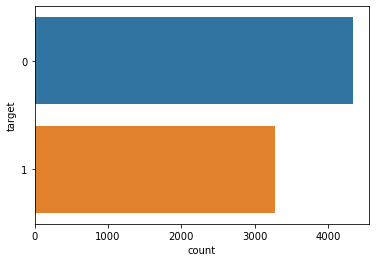

In [37]:
sns.countplot (y = 'target', data =train_df)

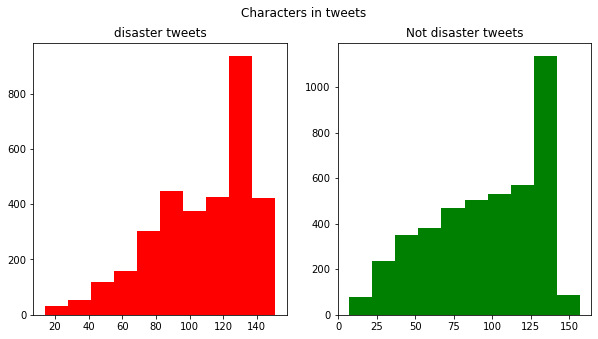

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_df[train_df['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

### TEXT CLEANING

In [39]:
# LOWERCASE REMOVAL

train_df["text_clean"] = train_df["text"].apply(lambda x: x.lower())
test_df["text_clean"] = test_df["text"].apply(lambda x: x.lower())

In [40]:
# SPECIAL CHARACTER REMOVAL

train_df['text']= train_df['text'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')
test_df['text']= test_df['text'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')


In [41]:
# REMOVE URL

def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_URL(x))
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: remove_URL(x))

In [42]:
# REMOVE HTML

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_html(x))
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: remove_html(x))

In [43]:
# REMOVE EMOJIS

def remove_emojis(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_emojis(x))
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: remove_emojis(x))

In [44]:
# REMOVE PUNCTUATION

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))


train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_punct(x))
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: remove_punct(x))


In [45]:
# REMOVAL OF NON-ASCII VALUES

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_non_ascii(x))
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: remove_non_ascii(x))


In [46]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ELCOT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ELCOT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# STOP WORDS REMOVAL

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

train_df['text'] = train_df['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
test_df['text'] = train_df['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))


### PREPROCESSING

#### FILLING MISSING VALUES

In [48]:
train_df.isnull().sum()

id               0
keyword         61
location      2533
text             0
target           0
text_clean       0
dtype: int64

In [49]:
test_df.isnull().sum()

id               0
keyword         26
location      1105
text             0
text_clean       0
dtype: int64

In [50]:
train_df['location'] = train_df['location'].fillna('None')
train_df['keyword'] = train_df['keyword'].fillna('None')
test_df['location'] = test_df['location'].fillna('None')
test_df['keyword'] = test_df['keyword'].fillna('None')

### DROP OF UNNESSESSARY FEATURE

In [51]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

### TOKENIZATION

In [52]:
# TOKENIZATION

import nltk
from nltk import TweetTokenizer

tokenizer = TweetTokenizer()

train_df['tokens'] = [tokenizer.tokenize(item) for item in train_df.text]
test_df['tokens'] = [tokenizer.tokenize(item) for item in test_df.text]

### Lemmatization

In [53]:
# LEMMATION

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        new_item.append(x)
    return " ".join(new_item)

train_df['tokens'] = [lemmatize_item(item) for item in train_df.tokens]
test_df['tokens'] = [lemmatize_item(item) for item in test_df.tokens]

### VECTORIZATION

In [54]:
# VECTORIZATION

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()


X = vectorizer.fit_transform(train_df.text).toarray()
y = train_df['target']

### MODEL DATA SPLITTING

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### LOGISTIC REGRESSION

In [56]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model 
log = LogisticRegression(random_state = 0)

# Fitting data
log.fit(X_train, y_train)

# Predicting the data
log_pred = log.predict(X_test)

### MODEL EVALUATION

### Accuracy

In [57]:
# MODEL EVALUATION FOR LOGISTIC REGRESSION

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
acc = accuracy_score(y_test,log_pred)
print("\nACCURACY : ",acc)


ACCURACY :  0.8069176882661997


### Classification Report

In [58]:
# Classification Report
clf_report = classification_report(y_test,log_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      1338
           1       0.81      0.70      0.75       946

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284



### Confusion Matrix


CONFUSION MATRIX:


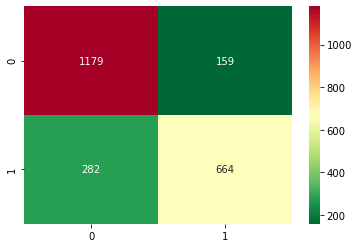

In [59]:
# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='g', cmap="RdYlGn_r")
plt.show()